# Nuclear Localization Quantification

## Imports

In [2]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits import mplot3d
from scipy.optimize import curve_fit
import scipy.stats as st

## Process Images

In [3]:
def findIntensities(images, nucleusColor, signalColor):
    # Define arrays to store distances from nuclei and signal intensities for all cells
    allDist = []
    allSignal = []
    allAverage = pd.DataFrame()
    
    # Define color dictionary and 
    colors = {'blue': 0, 'green': 1, 'red': 2, 'all':-1}
    maskColor = colors[nucleusColor]
    relevantColor = colors[signalColor]

    # Loop through all images
    for image in images:
        if image.endswith(".jpg"):
            image_path = path + '/' + image
            img = cv2.imread(image_path)
            
            # Determine gray image based on relevant channels
            if maskColor == -1:
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            else:
                gray = img[:,:,maskColor]
            
            # Apply blur, erosion, and thresholding
            blur = cv2.GaussianBlur(gray, (7,7), 0)
            kernel = np.ones((11,11), np.uint8)
            erode = cv2.erode(blur, kernel, iterations=1)
            ret, binImg = cv2.threshold(erode, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            
            # Obtain contours, with largest one being that of the nucleus
            # universal unpack
            contours, hierarchy = cv2.findContours(binImg.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            contours = list(contours)  # make sure it's a mutable list
            contours.sort(key=len, reverse=True)
            nucBound = contours[0]
            print(type(nucBound))
            print(nucBound)
            
            # Define arrays to store values for this nucleus
            oneNucDist = []
            oneNucSignal = []
            
            # Loop through all points. If in nulcear bound, find distance to contour and intensity at that point
            for y in range(gray.shape[0]):
                for x in range(gray.shape[1]):
                    dist = cv2.pointPolygonTest(nucBound, (x, y), True)
                    if dist >= 0:
                        oneNucDist.append(dist)
                        signal = img[y, x, relevantColor]
    #                     img[y,x,:] = [255, 255, 255]
                        oneNucSignal.append(signal)
    #         plt.figure(figsize=(3, 3))
    #         plt.imshow(img[:,:,::-1])
    
            # Normalize all distances to the maximum value
            maxDist = max(oneNucDist)
            oneNucDist = np.asarray(oneNucDist) / maxDist
            
            # Compute moving average calculation for each and add to data frame
            numberBins = 30
            averageSignal = binValues(oneNucDist, oneNucSignal, numberBins)
            allAverage[image] = averageSignal
            
            # Add this nucleus' data to that of all others
            allDist.append(oneNucDist)
            allSignal.append(oneNucSignal)
            
            # Visualize the boundary on the nucleus
#             cv2.drawContours(img, nucBound, -1, (0, 0, 255), 1)
#             plt.figure(figsize=(3, 3))
#             plt.imshow(img[:,:,::-1])
            
    # Compute the Average of Bins to determine the trend and confidence interval
    means = allAverage.mean(axis=1)
    lower_interval = []
    upper_interval = []
    for i in range(len(allAverage)):
        interval = st.t.interval(alpha=0.95, df=len(means[:])-1, loc=means[i], scale=st.sem(allAverage.iloc[i][:]))
        lower_interval.append(interval[0])
        upper_interval.append(interval[1])
    allAverage['mean'] = means
    allAverage['lower'] = lower_interval
    allAverage['upper'] = upper_interval
            
    return allAverage


In [4]:
# Allow for customization of the number of bins - within each bin, average of all points
# Bin with key value is all the points with that key value up to the next key
def binValues(oneNucDist, oneNucSignal, numberBins):
    distValues = {}
    bins = np.linspace(0, numberBins - 1, numberBins)
    bins = np.round(bins, 0)
    for b in bins:
        distValues[b] = []
    for i in range(len(oneNucDist)):
        dist = np.floor(oneNucDist[i] * numberBins)
        signal = oneNucSignal[i]
        if dist == numberBins:
            distValues[numberBins-1].append(signal)
        else:
            distValues[dist].append(signal)
    keys = list(distValues.keys())
    keys.sort()
    averageSignal = [np.mean(distValues[key]) for key in keys]
    return averageSignal 

## Project Data

### Lamin A/C Day 1 Chonrogenesis

In [11]:
# Fast
path = ""
images = os.listdir(path)
images.sort()
df_Lamin_Fast = findIntensities(images, 'all', 'green')


<class 'numpy.ndarray'>
[[[1026  917]]

 [[1025  918]]

 [[1024  918]]

 ...

 [[1029  917]]

 [[1028  917]]

 [[1027  917]]]
<class 'numpy.ndarray'>
[[[981 649]]

 [[981 650]]

 [[980 651]]

 ...

 [[984 651]]

 [[983 651]]

 [[982 650]]]
<class 'numpy.ndarray'>
[[[797 893]]

 [[796 894]]

 [[795 895]]

 ...

 [[800 893]]

 [[799 893]]

 [[798 893]]]
<class 'numpy.ndarray'>
[[[953 697]]

 [[952 698]]

 [[951 698]]

 ...

 [[956 697]]

 [[955 697]]

 [[954 697]]]
<class 'numpy.ndarray'>
[[[1031  760]]

 [[1030  761]]

 [[1029  762]]

 ...

 [[1034  760]]

 [[1033  760]]

 [[1032  760]]]
<class 'numpy.ndarray'>
[[[1050  682]]

 [[1049  683]]

 [[1048  683]]

 ...

 [[1053  682]]

 [[1052  682]]

 [[1051  682]]]
<class 'numpy.ndarray'>
[[[1011 1056]]

 [[1011 1057]]

 [[1011 1058]]

 ...

 [[1014 1059]]

 [[1013 1058]]

 [[1012 1057]]]
<class 'numpy.ndarray'>
[[[975 893]]

 [[974 894]]

 [[973 894]]

 ...

 [[978 894]]

 [[977 894]]

 [[976 893]]]
<class 'numpy.ndarray'>
[[[1604  533]]



/var/folders/_k/3rr4ld354m3dq5vw6t9q3rs00000gn/T/ipykernel_96618/4153006155.py:78: DeprecationWarning: Use of keyword argument 'alpha' for method 'interval' is deprecated and wil be removed in SciPy 1.11.0. Use first positional argument or keyword argument 'confidence' instead.
  interval = st.t.interval(alpha=0.95, df=len(means[:])-1, loc=means[i], scale=st.sem(allAverage.iloc[i][:]))


In [13]:
# SG
path = ""
images = os.listdir(path)
images.sort()
df_Lamin_SG = findIntensities(images, 'all', 'green')

<class 'numpy.ndarray'>
[[[755 927]]

 [[754 928]]

 [[753 928]]

 ...

 [[758 928]]

 [[757 928]]

 [[756 927]]]
<class 'numpy.ndarray'>
[[[ 806 1022]]

 [[ 805 1023]]

 [[ 804 1024]]

 ...

 [[ 809 1022]]

 [[ 808 1022]]

 [[ 807 1022]]]
<class 'numpy.ndarray'>
[[[935 753]]

 [[934 754]]

 [[934 755]]

 ...

 [[938 754]]

 [[937 754]]

 [[936 753]]]
<class 'numpy.ndarray'>
[[[880 893]]

 [[880 894]]

 [[879 895]]

 ...

 [[883 894]]

 [[882 894]]

 [[881 893]]]
<class 'numpy.ndarray'>
[[[1021  940]]

 [[1020  941]]

 [[1019  942]]

 ...

 [[1024  940]]

 [[1023  940]]

 [[1022  940]]]
<class 'numpy.ndarray'>
[[[630 607]]

 [[629 608]]

 [[628 608]]

 ...

 [[633 608]]

 [[632 608]]

 [[631 608]]]
<class 'numpy.ndarray'>
[[[1016 1147]]

 [[1015 1148]]

 [[1014 1149]]

 ...

 [[1019 1147]]

 [[1018 1147]]

 [[1017 1147]]]
<class 'numpy.ndarray'>
[[[963 708]]

 [[962 709]]

 [[961 709]]

 ...

 [[965 709]]

 [[965 708]]

 [[964 708]]]
<class 'numpy.ndarray'>
[[[992 824]]

 [[992 825]]



/var/folders/_k/3rr4ld354m3dq5vw6t9q3rs00000gn/T/ipykernel_96618/4153006155.py:78: DeprecationWarning: Use of keyword argument 'alpha' for method 'interval' is deprecated and wil be removed in SciPy 1.11.0. Use first positional argument or keyword argument 'confidence' instead.
  interval = st.t.interval(alpha=0.95, df=len(means[:])-1, loc=means[i], scale=st.sem(allAverage.iloc[i][:]))


In [14]:
df_Lamin_Fast.to_csv("Lamin_Fast.csv")
df_Lamin_SG.to_csv("Lamin_SG.csv")

In [27]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 50}

mpl.rc('font', **font)

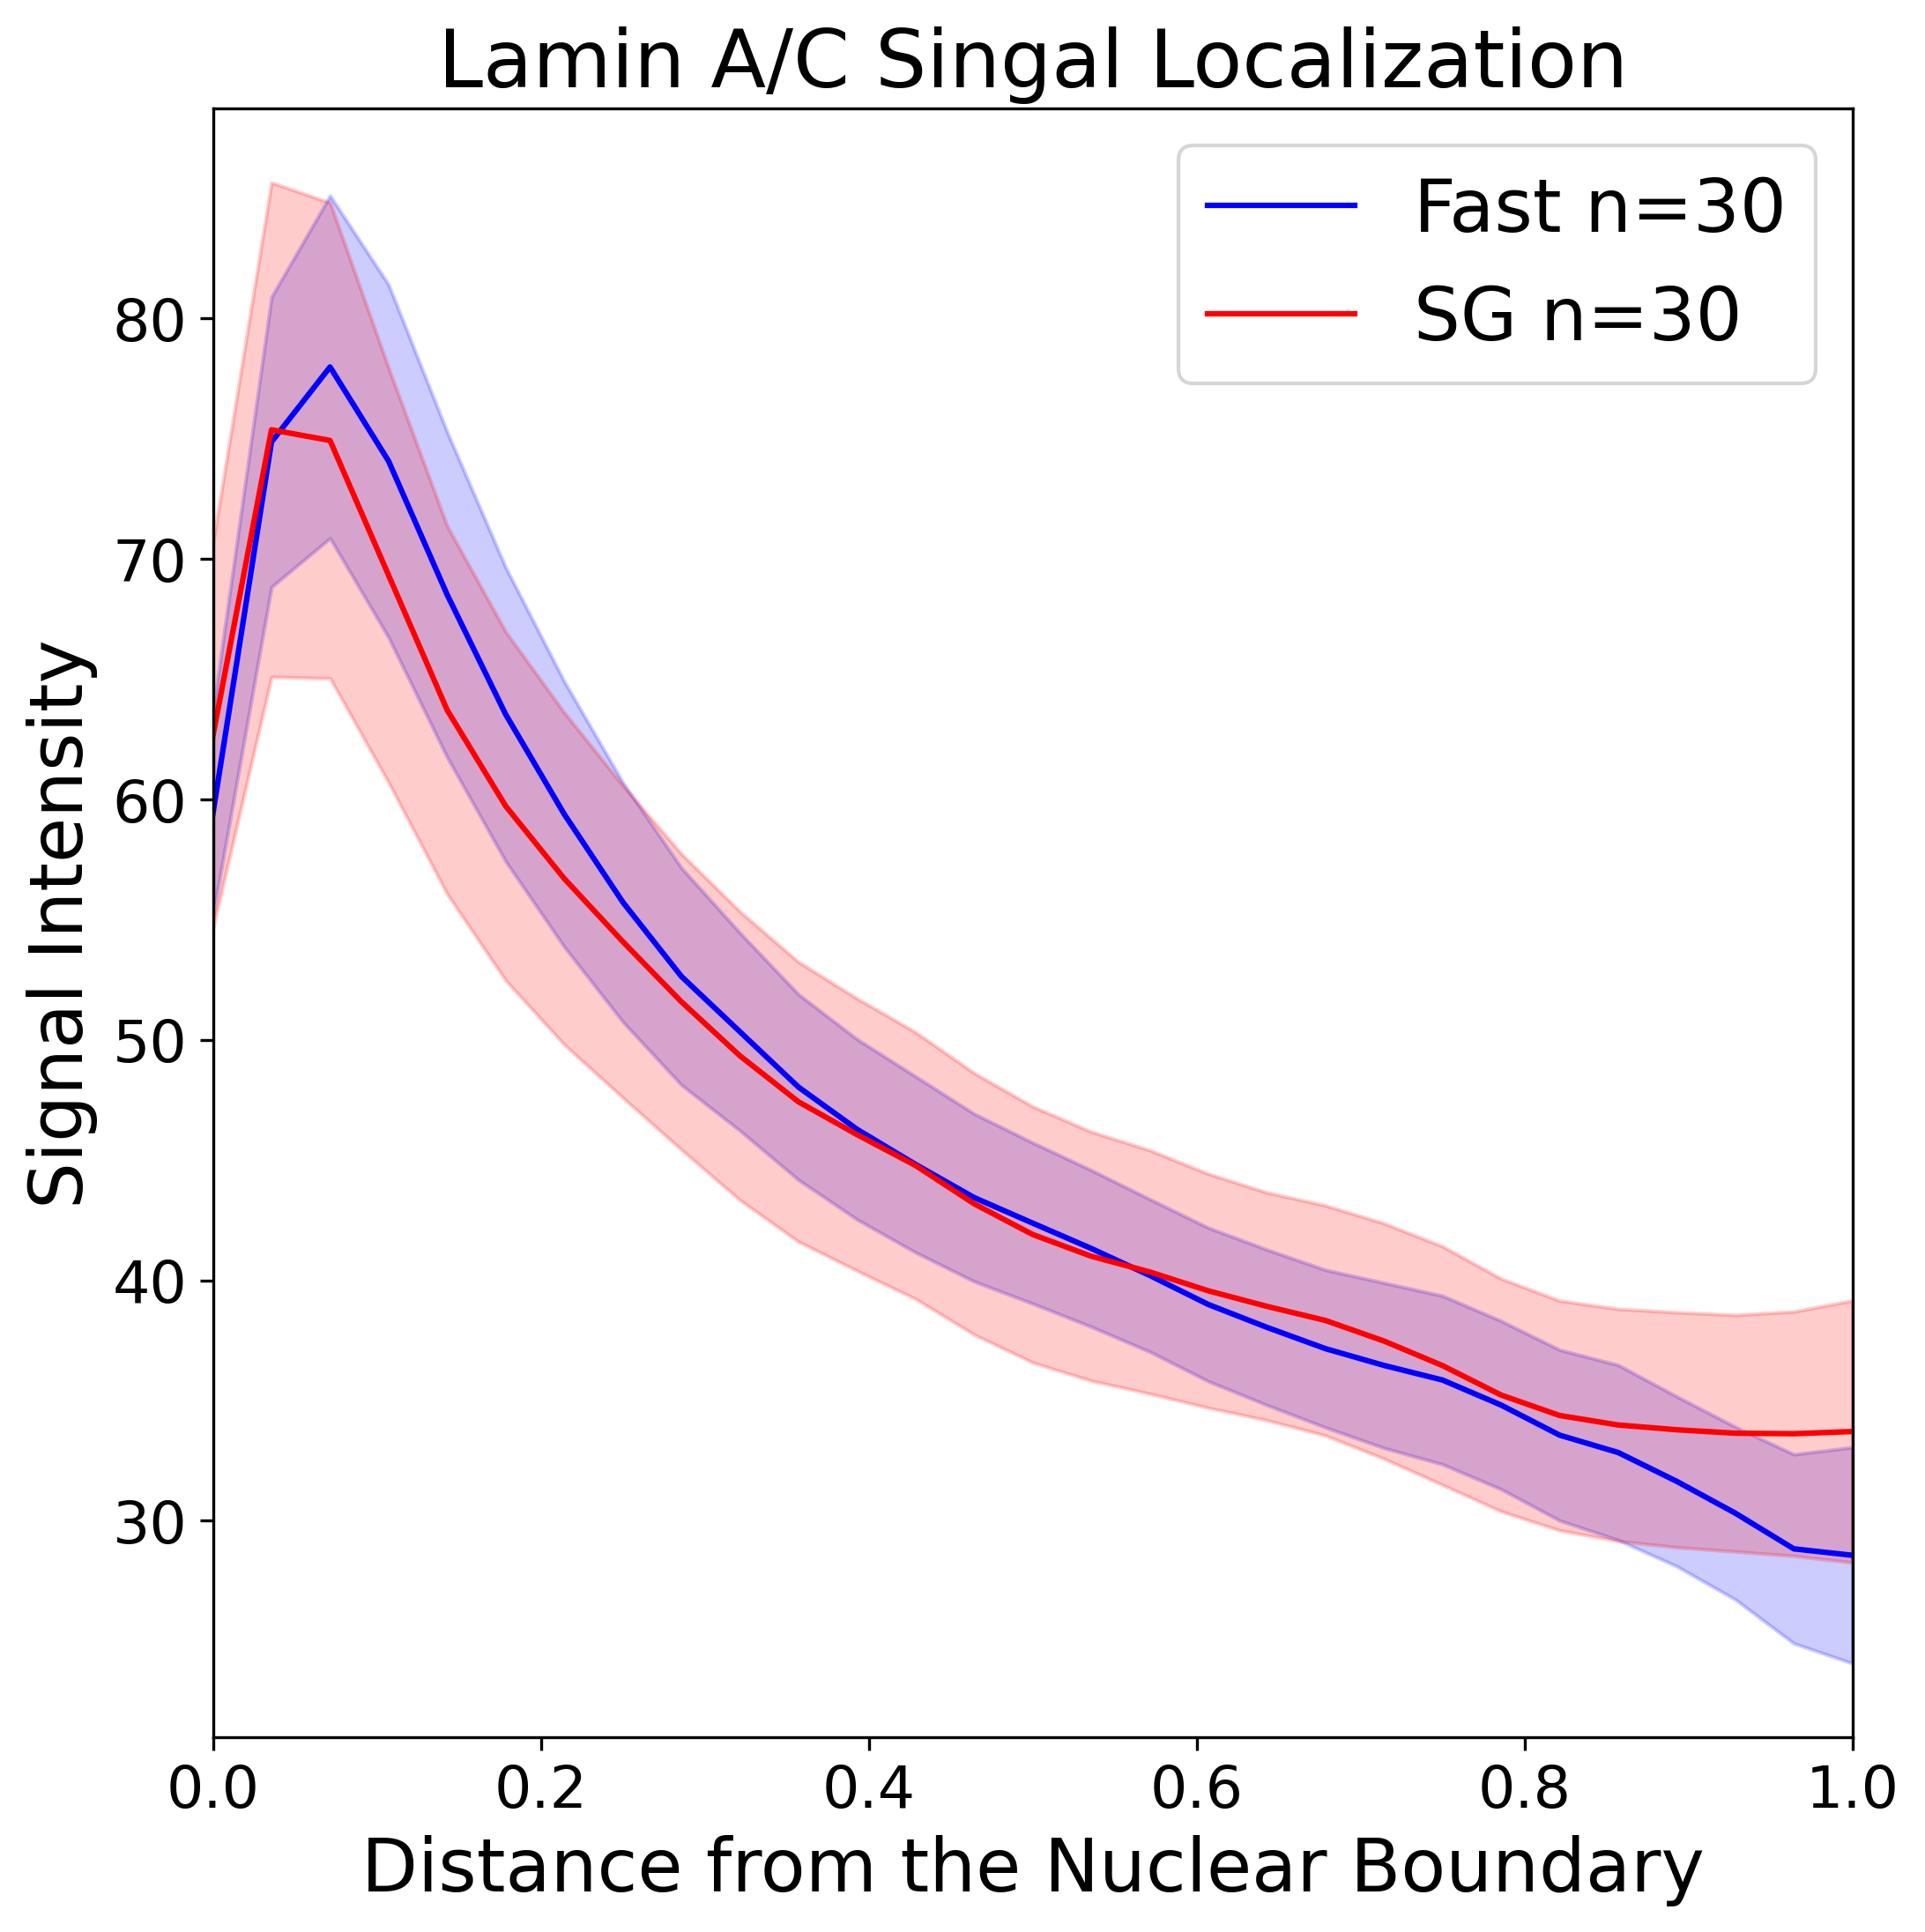

In [29]:
# d1 = df_Lamin_Fast
# d2 = df_Lamin_SG

d1 = pd.read_csv("Lamin_Fast.csv")
d2 = pd.read_csv("Lamin_SG.csv")

plt.figure(figsize=(8, 8), dpi=300)
plt.style.use('default')

n = len(d1)  
plt.plot(np.linspace(0,1,29), d1['mean'][:-1], color = '#0000FF', label=f"Fast n={n}")
plt.fill_between(np.linspace(0,1,29), d1['lower'][:-1], d1['upper'][:-1], color='#0000FF', alpha=0.2)

plt.plot(np.linspace(0,1,29), d2['mean'][:-1], color='#FF0000', label=f"SG n={n}")
plt.fill_between(np.linspace(0,1,29), d2['lower'][:-1], d2['upper'][:-1], color='#FF0000', alpha=0.2)

plt.xlabel('Distance from the Nuclear Boundary', fontsize=20)
plt.ylabel('Signal Intensity', fontsize=20)
plt.title('Lamin A/C Singal Localization',fontsize=22)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc="upper right", fontsize=20)
plt.xlim(0, 1)
plt.savefig("", dpi = 300)
plt.show()

### H3K9me3 Day 1 Chonrogenesis

In [14]:
# Fast
path = ""
images = os.listdir(path)
images.sort()
df_H3K9me3_Fast2 = findIntensities(images, 'blue', 'green')

<class 'numpy.ndarray'>
[[[1203  902]]

 [[1202  903]]

 [[1201  903]]

 ...

 [[1206  902]]

 [[1205  902]]

 [[1204  902]]]
<class 'numpy.ndarray'>
[[[1036  676]]

 [[1035  677]]

 [[1034  677]]

 ...

 [[1039  677]]

 [[1038  677]]

 [[1037  676]]]
<class 'numpy.ndarray'>
[[[963 301]]

 [[962 302]]

 [[961 302]]

 ...

 [[966 301]]

 [[965 301]]

 [[964 301]]]
<class 'numpy.ndarray'>
[[[1051  793]]

 [[1050  794]]

 [[1049  794]]

 ...

 [[1054  793]]

 [[1053  793]]

 [[1052  793]]]
<class 'numpy.ndarray'>
[[[1020  807]]

 [[1019  808]]

 [[1018  808]]

 ...

 [[1023  807]]

 [[1022  807]]

 [[1021  807]]]
<class 'numpy.ndarray'>
[[[960 823]]

 [[959 824]]

 [[958 824]]

 ...

 [[963 823]]

 [[962 823]]

 [[961 823]]]
<class 'numpy.ndarray'>
[[[1007  889]]

 [[1006  890]]

 [[1005  890]]

 ...

 [[1010  890]]

 [[1009  890]]

 [[1008  889]]]
<class 'numpy.ndarray'>
[[[1276  789]]

 [[1275  790]]

 [[1274  790]]

 ...

 [[1279  789]]

 [[1278  789]]

 [[1277  789]]]
<class 'numpy.nd

/var/folders/_k/3rr4ld354m3dq5vw6t9q3rs00000gn/T/ipykernel_18376/4153006155.py:78: DeprecationWarning: Use of keyword argument 'alpha' for method 'interval' is deprecated and wil be removed in SciPy 1.11.0. Use first positional argument or keyword argument 'confidence' instead.
  interval = st.t.interval(alpha=0.95, df=len(means[:])-1, loc=means[i], scale=st.sem(allAverage.iloc[i][:]))


In [15]:
# SG
path = ""
images = os.listdir(path)
images.sort()
df_H3K9me3_SG2 = findIntensities(images, 'blue', 'green')

<class 'numpy.ndarray'>
[[[904 816]]

 [[903 817]]

 [[902 817]]

 ...

 [[907 816]]

 [[906 816]]

 [[905 816]]]
<class 'numpy.ndarray'>
[[[966 782]]

 [[965 783]]

 [[964 783]]

 ...

 [[969 783]]

 [[968 783]]

 [[967 783]]]
<class 'numpy.ndarray'>
[[[956 841]]

 [[955 842]]

 [[954 842]]

 ...

 [[959 841]]

 [[958 841]]

 [[957 841]]]
<class 'numpy.ndarray'>
[[[ 938 1339]]

 [[ 937 1340]]

 [[ 936 1340]]

 ...

 [[ 941 1339]]

 [[ 940 1339]]

 [[ 939 1339]]]
<class 'numpy.ndarray'>
[[[1162  973]]

 [[1161  974]]

 [[1160  974]]

 ...

 [[1165  973]]

 [[1164  973]]

 [[1163  973]]]
<class 'numpy.ndarray'>
[[[1100  887]]

 [[1099  888]]

 [[1098  888]]

 ...

 [[1103  887]]

 [[1102  887]]

 [[1101  887]]]
<class 'numpy.ndarray'>
[[[810 517]]

 [[810 518]]

 [[810 519]]

 ...

 [[812 519]]

 [[811 519]]

 [[810 518]]]
<class 'numpy.ndarray'>
[[[840 862]]

 [[839 863]]

 [[838 863]]

 ...

 [[843 862]]

 [[842 862]]

 [[841 862]]]
<class 'numpy.ndarray'>
[[[971 867]]

 [[970 868]]



/var/folders/_k/3rr4ld354m3dq5vw6t9q3rs00000gn/T/ipykernel_18376/4153006155.py:78: DeprecationWarning: Use of keyword argument 'alpha' for method 'interval' is deprecated and wil be removed in SciPy 1.11.0. Use first positional argument or keyword argument 'confidence' instead.
  interval = st.t.interval(alpha=0.95, df=len(means[:])-1, loc=means[i], scale=st.sem(allAverage.iloc[i][:]))


In [17]:
df_H3K9me3_Fast2.to_csv("df_H3K9me3_Fast2.csv")
df_H3K9me3_SG2.to_csv("df_H3K9me3_SG2.csv")

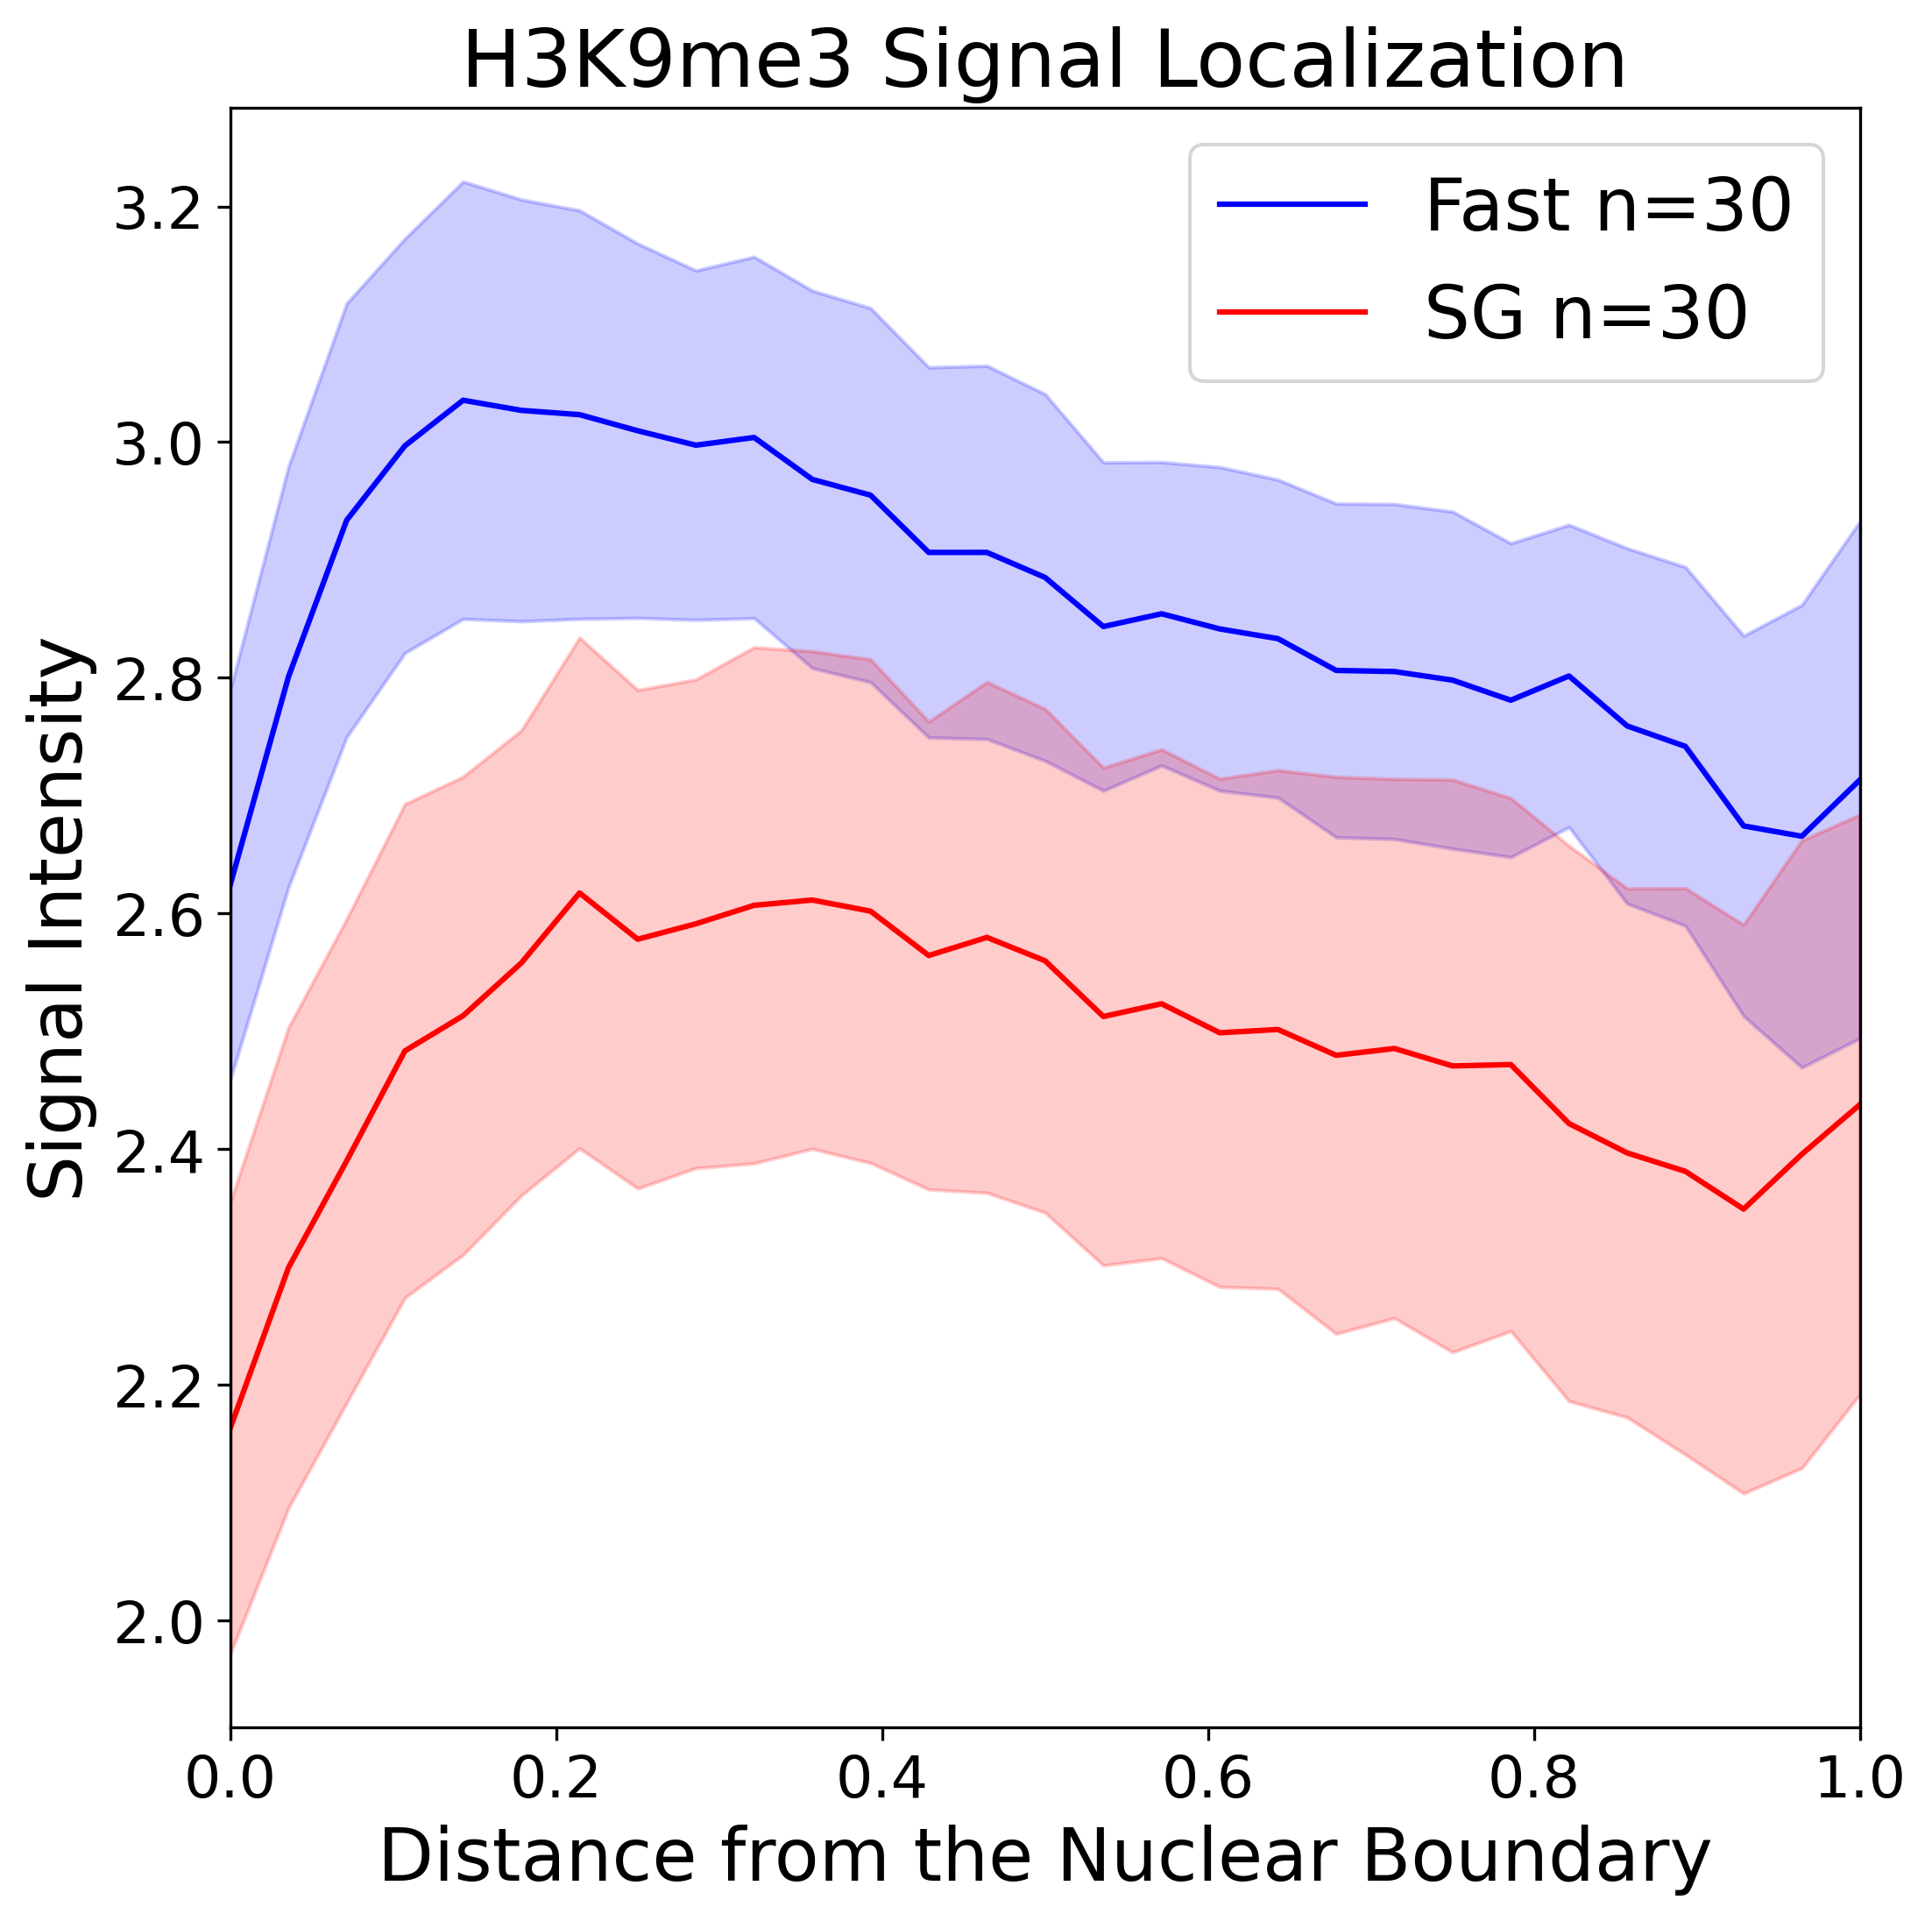

In [18]:
# d1 = df_H3K9me3_Fast
# d2 = df_H3K9me3_SG

d1 = pd.read_csv("df_H3K9me3_Fast2.csv")
d2 = pd.read_csv("df_H3K9me3_SG2.csv")

plt.figure(figsize=(8, 8), dpi=300)
plt.style.use('default')

plt.plot(np.linspace(0,1,29), d1['mean'][:-1], color = '#0000FF', label="Fast n=" + str(len(d1.columns)-4))
plt.fill_between(np.linspace(0,1,29), d1['lower'][:-1], d1['upper'][:-1], color='#0000FF', alpha=0.2)

plt.plot(np.linspace(0,1,29), d2['mean'][:-1], color='#FF0000', label="SG n=" + str(len(d2.columns)-4))
plt.fill_between(np.linspace(0,1,29), d2['lower'][:-1], d2['upper'][:-1], color='#FF0000', alpha=0.2)

plt.xlabel('Distance from the Nuclear Boundary', fontsize=20)
plt.ylabel('Signal Intensity', fontsize=20)
plt.title('H3K9me3 Signal Localization', fontsize=22)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc="upper right", fontsize=20)
plt.xlim(0, 1)
plt.savefig("H3K9me3 Chondro D1_2.png", dpi = 300)
plt.show()